In [1]:
import pandas as pd
import math
import re
from collections import Counter
from itertools import combinations

In [2]:
path = r'D:\Yelp\charlotte_2016_groups.csv'

In [3]:
df = pd.read_csv(path, index_col=0)

In [4]:
df['date'] =  pd.to_datetime(df['date'])

In [5]:
df.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars_business', 'review_count', 'is_open',
       'attributes', 'categories', 'hours', 'review_id', 'user_id', 'stars',
       'useful', 'funny', 'cool', 'text', 'date', 'group_id', 'group_len',
       'group_type'],
      dtype='object')

In [6]:
df

,business_id,name,address,city,state,postal_code,latitude,longitude,stars_business,review_count,...,user_id,stars,useful,funny,cool,text,date,group_id,group_len,group_type
0,0pOlmHVeidsh63iAWdTAfg,Hendrick Motors of Charlotte - Mercedes-Benz,5201 E Independence Blvd,Charlotte,NC,28212.0,35.188018,-80.758758,2.5,32,...,A0R17nyHQ9SiqQjtnsP33g,1.0,5,0,0,Mercedes used to be such a great brand with ex...,2016-12-23 03:54:01,NaN,NaN,NaN
1,0pOlmHVeidsh63iAWdTAfg,Hendrick Motors of Charlotte - Mercedes-Benz,5201 E Independence Blvd,Charlotte,NC,28212.0,35.188018,-80.758758,2.5,32,...,hpSViZNe-5eZaVSgi9LkZw,1.0,9,0,0,Horrible experience! Purchased a ML350 from he...,2016-02-14 04:09:06,5284.0,2.0,n
2,-qjn24n8HYF6It9GQrQntw,Five Guys Burgers and Fries,2130 E Arbors Dr,Charlotte,NC,28262.0,35.338070,-80.757397,4.0,15,...,17TiV5o3EsIIbyFgSpBmXg,4.0,0,0,0,Always good fresh juicy burgers. They are a bi...,2016-08-13 04:18:40,209.0,4.0,n
3,-qjn24n8HYF6It9GQrQntw,Five Guys Burgers and Fries,2130 E Arbors Dr,Charlotte,NC,28262.0,35.338070,-80.757397,4.0,15,...,17TiV5o3EsIIbyFgSpBmXg,4.0,0,0,0,Always good fresh juicy burgers. They are a bi...,2016-08-13 04:18:40,1152.0,14.0,n
4,-qjn24n8HYF6It9GQrQntw,Five Guys Burgers and Fries,2130 E Arbors Dr,Charlotte,NC,28262.0,35.338070,-80.757397,4.0,15,...,17TiV5o3EsIIbyFgSpBmXg,4.0,0,0,0,Always good fresh juicy burgers. They are a bi...,2016-08-13 04:18:40,1153.0,12.0,n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262210,_JA3TLF5JJ95mthVwEdFuw,Steak ’n Shake,1926 Sardis Rd N,Charlotte,NC,28270.0,35.140920,-80.732982,2.0,88,...,CCE-S9fOl6oZgiaPMi9TXA,1.0,0,0,0,If I could give these people 0 stars I would. ...,2016-03-13 06:41:19,8100.0,2.0,n
262211,_JA3TLF5JJ95mthVwEdFuw,Steak ’n Shake,1926 Sardis Rd N,Charlotte,NC,28270.0,35.140920,-80.732982,2.0,88,...,jJAi1T5DUSwuccjafLXTHQ,1.0,0,0,0,"The line took forever, order and pay for our f...",2016-11-18 01:12:36,NaN,NaN,NaN
262212,_JA3TLF5JJ95mthVwEdFuw,Steak ’n Shake,1926 Sardis Rd N,Charlotte,NC,28270.0,35.140920,-80.732982,2.0,88,...,QRNzgxnW4uVkWZNkt9mH8w,1.0,0,0,0,I have been told by many people that this is ...,2016-10-13 01:15:55,NaN,NaN,NaN
262213,_JA3TLF5JJ95mthVwEdFuw,Steak ’n Shake,1926 Sardis Rd N,Charlotte,NC,28270.0,35.140920,-80.732982,2.0,88,...,QRNzgxnW4uVkWZNkt9mH8w,5.0,0,0,0,Holy cow!!! I am not a fan of eating out but t...,2016-09-16 01:32:59,NaN,NaN,NaN


In [7]:
len(df.group_id.unique())

8603

## Reveiwer Centric Reviewing Burstiness (𝑩𝑺𝑻) and Own Review Count

In [8]:
t = 28

In [9]:
def get_review_burstiness(df, t):

    result = []
    groups = df.groupby('user_id')

    for user_id, data in groups:

        data.drop_duplicates(subset='review_id', inplace=True)

        #print(type(data))
        #print(user_id)
        #print(data.date)
        #print(data.review_id)
        #print(data.text)
        _max = data.date.max()
        _min = data.date.min()
        
        review_count = len(data)
        
        diff = _max - _min
        
        if diff.total_seconds() == 0:
            bst = 0
            result.append({'user_id': user_id, 'bst': bst, 'own_review_count': review_count})
            continue
        else: 
            days = diff.days
            if days == 0:
                days = 1
        if days < t:
            bst = 1-(days/t)
        else:
            bst = 0
        result.append({'user_id': user_id, 'bst': bst, 'own_review_count': review_count})
        #print(result)
    df_result = pd.DataFrame(result)
    #df_result.drop_duplicates(subset='user_id', inplace=True)
    return df_result

In [10]:
df_bst = get_review_burstiness(df, t)

In [19]:
df_bst.shape

(23691, 3)

In [20]:
df_bst = df_bst.drop_duplicates()

In [21]:
df_bst.shape

(23691, 3)

In [16]:
df_bst.head()

,user_id,bst,own_review_count
0,--3WaS23LcIXtxyFULJHTA,0.964286,2
1,--7D3lFxyMYvs2JYiRrg6Q,0.000000,1
2,--JS-RvSykutl1DavCbkIg,0.000000,1
3,--OZO4c_vDOVC2z2BWr92A,0.964286,2
4,--wiweOmNCw6vg2kbzbwEA,0.000000,1


In [17]:
path = r'D:\Yelp\bst_own_review_count_groups.csv'

In [18]:
df_bst.to_csv(path)

## Merge

In [35]:
df_merged = df.merge(df_bst, on='user_id')

<AxesSubplot:xlabel='group_id'>

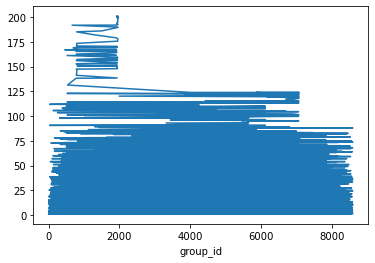

In [52]:
df_merged.groupby(['group_id']).own_review_count.mean().sort_values(ascending=False).plot()

In [58]:
s = df_merged.groupby(['group_id', 'own_review_count']).bst.mean().sort_values(ascending=False).to_frame().reset_index()

In [71]:
s = s.set_index('group_id')

In [75]:
s.index = s.index.map(str)

In [80]:
s

,own_review_count,bst
group_id,,
6345.0,4,0.964286
3917.0,3,0.964286
3324.0,3,0.964286
368.0,2,0.964286
3927.0,4,0.964286
...,...,...
5190.0,2,0.000000
5190.0,1,0.000000
5189.0,1,0.000000


<AxesSubplot:xlabel='group_id'>

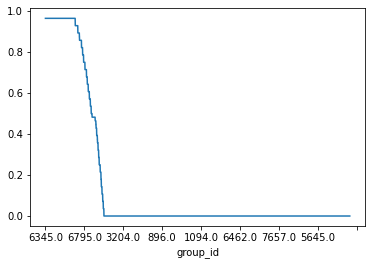

In [82]:
s.bst.plot()

<AxesSubplot:xlabel='group_id'>

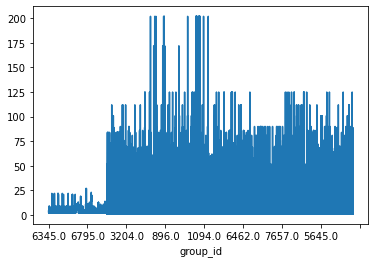

In [81]:
s.own_review_count.plot()

In [ ]:
s.bst.plot()

In [41]:
s = df_merged[df_merged.user_id=='0KJUheGDsmXcU9h4PHMBrg'][['text','review_id', 'group_id', 'own_review_count']]

In [42]:
s.drop_duplicates(subset='review_id', inplace=True)

In [43]:
s

,text,review_id,group_id,own_review_count
236800,Peruvian food is finally getting some recognit...,QucEXeu-OF4k8bKlf6O1ig,45.0,3
236805,"Sabor is delicious! Great authentic tacos, Me...",pR6JRHeEyIJ3vClSGStIZg,45.0,3
236810,How have I never reviewed Amelie's? The salte...,gv5ttJ9Z1M56kyeC38kMLQ,45.0,3


In [84]:
path = r'D:\Yelp\bst_own_review_count_groups.csv'

In [85]:
df_merged.to_csv(path)